In [1]:
from sklearn.manifold import TSNE
import torch.nn as nn
from torchvision import datasets, transforms

from model import VaDE, cluster_acc
from dataloader import *

In [2]:
train = MNIST(root = 'dataset/mnist/', train=True, download=True, transform=transforms.ToTensor())
test = MNIST(root = 'dataset/mnist/', train=False, download=True, transform=transforms.ToTensor())

# For plotting
plot_points = {}
for t in range(10):
    points = torch.cat([data for data, label in train if label == t])
    points = points.view(-1, 784)[:128].to('cuda:1')
    plot_points[t] = points

xs = []
ts = []
for t, x in plot_points.items():
    xs.append(x)
    t = torch.full((x.size(0), ), t, dtype=torch.long)
    ts.append(t)
plot_points = (torch.cat(xs, dim=0), torch.cat(ts, dim=0))


In [3]:
from argparse import Namespace

args = Namespace()
args.batch_size = 800
args.datadir = 'dataset/mnist/'
args.nClusters = 10
args.hid_dim = 10
args.cuda = True
args.device = 'cuda:1'


model = VaDE(args=args)
model.load_state_dict(torch.load('pretrain_model.pk'))
model.to('cuda:1')

/tmp/ipykernel_170229/3317722212.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pretrain_model.pk'))


VaDE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=500, out_features=500, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=500, out_features=2000, bias=True)
      (5): ReLU(inplace=True)
    )
    (mu_l): Linear(in_features=2000, out_features=10, bias=True)
    (log_sigma2_l): Linear(in_features=2000, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=2000, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=2000, out_features=500, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=500, out_features=500, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=500, out_features=784, bias=True)
      (7): Sigmoid()
    )
  )
)

(1280, 10)


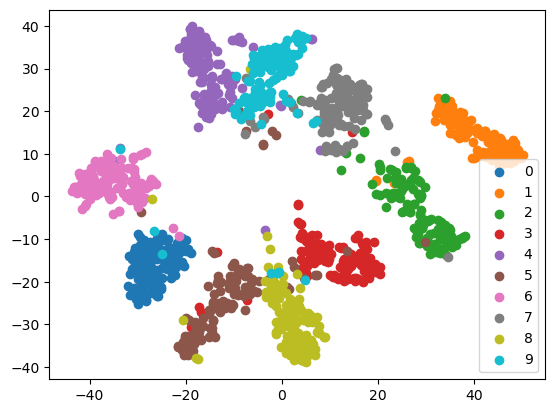

In [7]:
import matplotlib.pyplot as plt

# Plot latent space
xs, ts = plot_points[0].to(args.device), plot_points[1].to(args.device)
zs = model.encoder(xs)[0].cpu().detach().numpy()
print(zs.shape)

tsne = TSNE(n_components=2, init='pca')
zs_tsne = tsne.fit_transform(xs.cpu().numpy())

fig, ax = plt.subplots()
cmap = plt.get_cmap('tab10')
for t in range(10):
    points = zs_tsne[ts.cpu().numpy() == t]
    ax.scatter(points[:, 0], points[:, 1], color=cmap(t), label=str(t))
ax.legend()
